In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import scipy.stats as stats

In [4]:
import pymc3 as pm

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [5]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

# Gaussian process models

Suppose we want to model some observed data with noise $\epsilon$ as samples from a normal distribution

$$
    y \sim \mathcal{N}(\mu = f(x), \sigma=\epsilon)
$$

For example, if $f(x) = ax + b$, we have simple linear regression. 

Gaussian process models let us put a prior over $f$

$$
f(x) \sim \mathcal{GP}(\mu_x, K(x, x^T, h))
$$

where $\mu_x$ is the mean function and $K(x, x^T)$ is the covariance or kernel function and $h$ is a bandwidth parameter that determines the amount of smoothing.

This results in a very flexible modeling framework, since we can in principal model arbitrary curves and surfaces, so long as the noise can be approximated by a Gaussian. In fact, the classical linear and generalized models can be considered special cases of the Gaussian process model.

## Generative model

In [6]:
def gauss_kernel(x, knots, h):
    return np.array([np.exp(-(x-k)**2/(2*h**2)) for k in knots])

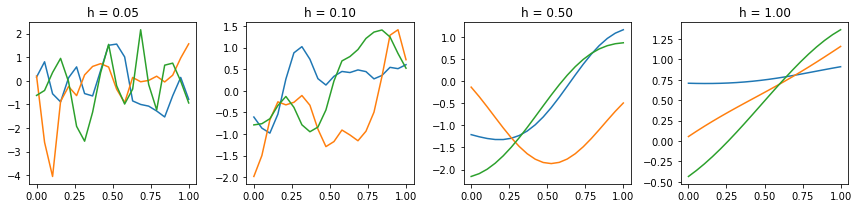

In [7]:
plt.figure(figsize=(12,3))
hs = hs=[0.05, 0.1, 0.5, 1]
x = np.linspace(0, 1, 20)
for i, h in enumerate(hs):
    plt.subplot(1,4,i+1)
    for j in range(3):
        plt.plot(x, stats.multivariate_normal.rvs(cov=gauss_kernel(x, x, h)))
    plt.title('h = %.2f' % h)
plt.tight_layout()

## Simple example of sampling from a GP model

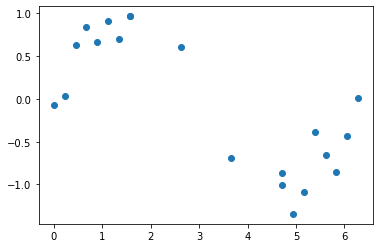

In [8]:
n = 20
x = np.r_[np.linspace(0, 0.5*np.pi, 8),
          np.linspace(0.5*np.pi, 1.5*np.pi, 4),
          np.linspace(1.5*np.pi, 2*np.pi, 8)]
y = np.sin(x) + np.random.normal(0, 0.2, n)
plt.plot(x, y, 'o')
pass

In [9]:
X = np.c_[x]

In [10]:
with pm.Model() as gp1:
    h = pm.Gamma('h', 2, 0.5)
    c = pm.gp.cov.ExpQuad(1, ls=h)
    gp = pm.gp.Marginal(cov_func=c)
    ϵ = pm.HalfCauchy('ϵ', 1)
    y_est = gp.marginal_likelihood('y_est', X=X, y=y, noise=ϵ)

In [11]:
with gp1:
    trace = pm.sample(tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, h]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [00:06<00:00, 977.76draws/s] 


/opt/conda/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/opt/conda/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


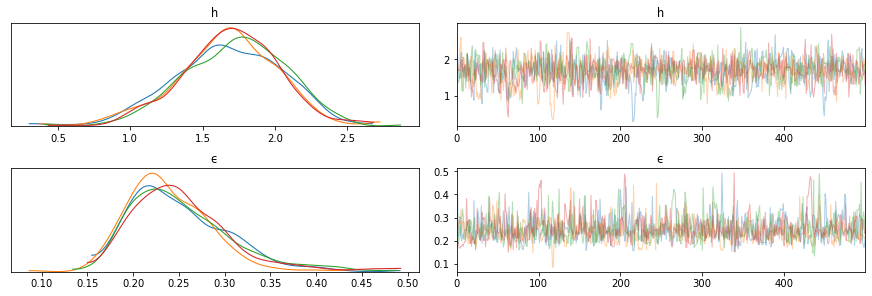

In [12]:
pm.traceplot(trace)
pass

In [13]:
xp = np.c_[np.linspace(0, 2*np.pi, 100)]

with gp1:
    fp = gp.conditional('fp', xp)
    ppc = pm.sample_posterior_predictive(trace, vars=[fp], samples=100)

/opt/conda/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 100/100 [00:05<00:00, 18.46it/s]


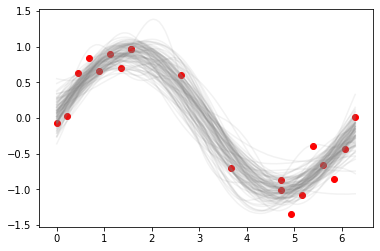

In [14]:
plt.plot(xp, ppc['fp'].T, c='grey', alpha=0.1)
plt.scatter(x, y, c='red')
pass

### Utility plot showing percentiles from 51 to 99

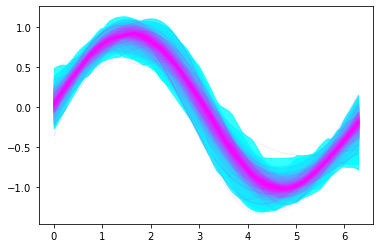

In [15]:
ax = plt.subplot(111)
pm.gp.util.plot_gp_dist(ax, ppc['fp'], xp, palette='cool')
pass